In [9]:
%autoreload 2 
%matplotlib ipympl

import numpy as np 
from pianoq.misc.mplt import mplot, mimshow
from pianoq.simulations.abstract_quantum_scaling.qwfs_simulation import QWFSSimulation
from pianoq.simulations.abstract_quantum_scaling.qwfs_result import QWFSResult
from pianoq.misc.mplc_writeup_imports import *

In [10]:
path = r"G:\My Drive\Projects\MPLC\results\simulations\2024_11_26_16_55_09_qwfs_long_with_analytic.npz"
res = QWFSResult(path)

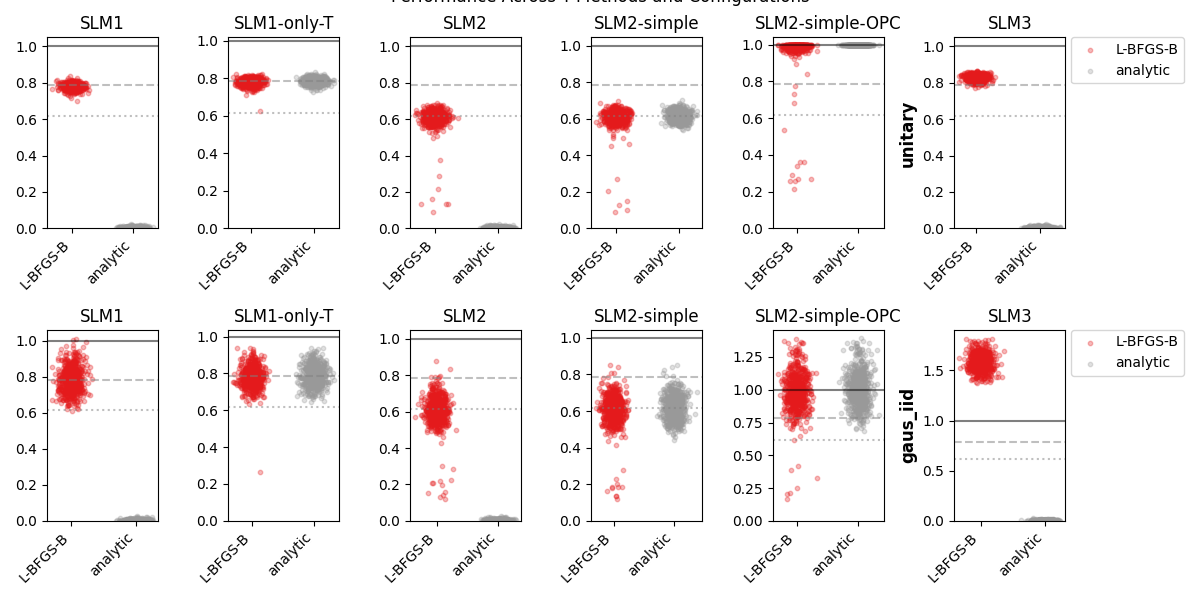

In [11]:
res.show_scatterplots()
plt.show(block=False)

In [12]:
res.print()

---- SLM1 ----
-- unitary --
L-BFGS-B                  0.782+-0.02
analytic                  0.004+-0.00
-- gaus_iid --
L-BFGS-B                  0.786+-0.07
analytic                  0.004+-0.00

---- SLM1-only-T ----
-- unitary --
L-BFGS-B                  0.781+-0.02
analytic                  0.786+-0.02
-- gaus_iid --
L-BFGS-B                  0.782+-0.06
analytic                  0.787+-0.05

---- SLM2 ----
-- unitary --
L-BFGS-B                  0.604+-0.06
analytic                  0.004+-0.00
-- gaus_iid --
L-BFGS-B                  0.604+-0.09
analytic                  0.004+-0.00

---- SLM2-simple ----
-- unitary --
L-BFGS-B                  0.606+-0.05
analytic                  0.617+-0.03
-- gaus_iid --
L-BFGS-B                  0.604+-0.09
analytic                  0.618+-0.06

---- SLM2-simple-OPC ----
-- unitary --
L-BFGS-B                  0.977+-0.09
analytic                  1.000+-0.00
-- gaus_iid --
L-BFGS-B                  0.986+-0.15
analytic                  1.0

And it seems that the simulation is all more or less OK:
* For SLM1 with and without the FFT etc. we get the $\pi / 4$, both analytically and with the nonlinear search. 
* Same for SLM2 configuration, and for OPC. 
* In both cases the spread of results is wider with the Gaussian IID than with unitary matrices, but this is expected. 
* The nonlinear search sometimes fails. 
* SLM3 is indeed $0.83 > \pi / 4$ for unitary, and $\approx 1.5$ for Gaussian IID, which is interesting! 

So basically now I can forget about all the SLM1,SLM2,OPC, since they all work and make sense, and only need to think better about the SLM3 configuration, why we get more than $\pi/4$ and why we get $1.5$! These are two questions with probably pretty different answers. The 0.83 might be the result of some mathematical reasoning. The 1.5 has something to do with energy harvesting somehow. We should look at the intensity distribution at different places to see what's what. 